In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

import tensorflow as tf
from glob import glob
from google.colab import drive
import os
import shutil
import cv2
from google.colab.patches import cv2_imshow
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:
#드라이브에 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#심슨 데이터 셋 받아오기
!cp "/content/drive/My Drive/simpson/simpson.zip" ./
!unzip -qq /content/simpson.zip -d /content/
!rm -r ./simplified
!mkdir ./train_simpson
%cd train_simpson
!mkdir image
%cd /content
!mv ./cropped/* ./train_simpson/image

/content/train_simpson
/content


In [4]:
#심슨 데이터 개수 조절
%cd /content/train_simpson/image
!ls /content/train_simpson/image -U | head -8877 | xargs rm -rf
%cd /content

/content/train_simpson/image
/content


In [5]:
#심슨 데이터 제대로 받아 왔는지 확인
train_simson_paths = glob(os.path.join('/content', 'train_simpson','image','*'))
len(train_simson_paths)

1000

In [6]:
#얼굴 데이터셋 받아오기
!mkdir temp
!mkdir train_real
%cd train_real
!mkdir image
%cd /content
!cp "/content/drive/My Drive/simpson/real.zip" ./temp/
!unzip -qq /content/temp/real.zip -d /content/temp/
target_dir = glob(os.path.join('/content', 'train_real','image'))
source_dirs = glob(os.path.join('/content','temp','lfw-deepfunneled','*','*'))

for source_dir in source_dirs:
    file_names = os.listdir(source_dir)
    for file_name in file_names:
        shutil.move(os.path.join(source_dir, file_name), target_dir[0])
!rm -r temp

/content/train_real
/content


In [7]:
#얼굴 데이터 개수 조절
%cd /content/train_real/image
!ls /content/train_real/image -U | head -12233 | xargs rm -rf
%cd /content

/content/train_real/image
/content


In [8]:
#얼굴 데이터 제대로 받아 왔는지 확인
train_real_paths = glob(os.path.join('/content', 'train_real','image','*'))
len(train_real_paths)

1000

In [9]:
import tensorflow as tf
data_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False,
    vertical_flip=False, rescale=None, preprocessing_function=None,
    data_format=None, validation_split=0.0, dtype=None
)

In [10]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def image_generator(flow_gen):
    
    for img in flow_gen:
        img=preprocess_image_train(img[0][0],1)
        img=tf.reshape(img,(-1,IMG_HEIGHT,IMG_WIDTH,3))
        yield img

In [11]:
simpson_gen=data_gen.flow_from_directory("/content/train_simpson",classes=None,seed=7,shuffle=True,batch_size=1)
simpson_gen=image_generator(simpson_gen)
real_gen=data_gen.flow_from_directory("/content/train_real",classes=None,seed=7,shuffle=True,batch_size=1)
real_gen=image_generator(real_gen)
sample_real=next(real_gen)

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


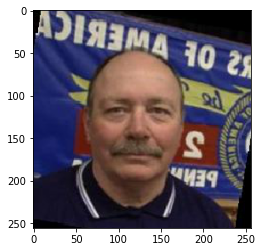

In [12]:
plt.imshow(sample_real[0]*0.5+0.5)

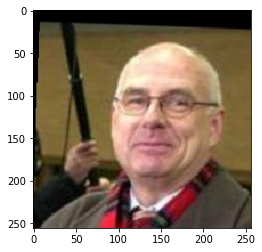

In [13]:
plt.imshow(next(real_gen)[0]*0.5+0.5)

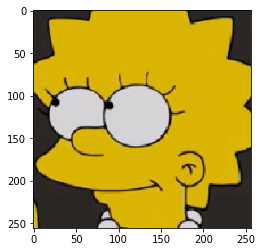

In [14]:
plt.imshow(next(simpson_gen)[0]*0.5+0.5)

In [15]:
simpson_gen=data_gen.flow_from_directory("/content/train_simpson",classes=None,seed=7,shuffle=True,batch_size=1)
simpson_gen=image_generator(simpson_gen)
real_gen=data_gen.flow_from_directory("/content/train_real",classes=None,seed=7,shuffle=True,batch_size=1)
real_gen=image_generator(real_gen)

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


In [16]:
#모델 선언

OUTPUT_CHANNELS = 3

#pix2pix 생성자 판별자 생성
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


#판별자 손실 함수
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

#생성자 손실 함수
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


LAMBDA = 0.1

#사이클 손실 함수
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

#identity 손실 함수
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [17]:

  
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [18]:
checkpoint_path = "/content/drive/MyDrive/simpson/checkpoints"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [19]:
def generate_images(model, test_input,epoch):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('/content/drive/MyDrive/simpson/checkpoints/image/'+str(epoch))


In [ ]:
EPOCHS=200
STEP_SIZE = 1000
for epoch in range(EPOCHS):
  start = time.time()
  n = 0
  step=0
  for image_x, image_y in zip(real_gen, simpson_gen):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    if step>STEP_SIZE:
        break
    step+=1
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_real,epoch)

  if 1:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Saving checkpoint for epoch 16 at /content/drive/MyDrive/simpson/checkpoints/ckpt-16
Time taken for epoch 16 is 446.7281563282013 sec

.........................

In [ ]:
!ls -l

In [ ]:
sample_real=next(real_gen)
generate_images(generator_g, sample_real,123)